# 90-803: Sprint 3

## Team 15: Kaia Hu, Megan Ty

Link to Download Data: https://drive.google.com/drive/folders/1RxgED3M7aPIH40KomLbKEfYCXuSd4RuL?usp=sharing 

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [54]:
# Only run this cell in your initial try

# Import dataset
housing = pd.read_csv('ahs2017n.csv')

# Gets occupied units only. Filters from metadata. 
df_occupied = housing.loc[housing['INTSTATUS']=="'1'"]
df_occupied.to_csv('Occupied_units.csv')

In [55]:
df_occupied = pd.read_csv('Occupied_units.csv')

# Getting important features

This census dataset has about 3000 columns, across n categories. 

To reduce dimensionality, we start with either (1) one-two representative variable for each category that is expected to not be correlated with transportation and (2) for categories that are expected to be very correlated, we take several variables. 

## Categories and associated variables to be included
Please see data_dictionary.md



In [56]:
# Let's start with some features we think will be important 
features_list = ['YRBUILT', 'FOUNDTYPE', 'BLD', 'UNITSIZE', 'HEATFUEL', 
                 'WATSOURCE', 'ADEQUACY', 'MOVWHY', 'RMJOB', 'RMOWNHH', 
                 'RMFAMILY', 'RMCHANGE', 'RMCOMMUTE', 'RMHOME', 'RMCOSTS', 
                 'RMHOOD', 'RMOTHER', 'SEARCHSTOP', 'NRATE', 
                 'HINCP', 'DISHH', 'HHRACE', 'HHGRAD', 
                 'RENTCNTRL', 'HUDSUB',
                 'DPEVVEHIC', 'DBMISSMORT', 
                 'HHCITSHP', 'NUMPEOPLE',
                 'MULTIGEN', 'MARKETVAL', 'RATINGNH', 'NHQSCHOOL', 'NHQPUBTRN', 'TOTHCAMT', 'GARAGE', 
                 'COMDAYS', 'DRIVEALL', 'DIST', 'BUS', 
                 'SUBWAY', 'VAN', 'COMTYPE', 'COMCOST', 'SUBSIDY']
df_occupied_features = df_occupied[features_list]

In [57]:
# Check for nulls
print(df_occupied_features.isnull().sum(axis=0))

YRBUILT       0
FOUNDTYPE     0
BLD           0
UNITSIZE      0
HEATFUEL      0
WATSOURCE     0
ADEQUACY      0
MOVWHY        0
RMJOB         0
RMOWNHH       0
RMFAMILY      0
RMCHANGE      0
RMCOMMUTE     0
RMHOME        0
RMCOSTS       0
RMHOOD        0
RMOTHER       0
SEARCHSTOP    0
NRATE         0
HINCP         0
DISHH         0
HHRACE        0
HHGRAD        0
RENTCNTRL     0
HUDSUB        0
DPEVVEHIC     0
DBMISSMORT    0
HHCITSHP      0
NUMPEOPLE     0
MULTIGEN      0
MARKETVAL     0
RATINGNH      0
NHQSCHOOL     0
NHQPUBTRN     0
TOTHCAMT      0
GARAGE        0
COMDAYS       0
DRIVEALL      0
DIST          0
BUS           0
SUBWAY        0
VAN           0
COMTYPE       0
COMCOST       0
SUBSIDY       0
dtype: int64


In [58]:
# there are a lot of pesky single quotation marks that need to be removed. 
df = df_occupied_features.applymap(lambda x: x.replace('\'', '') if (isinstance(x, str)) else x)
df = df.astype(int) 
# There is a strange abundance of -9s in this dataset. 
# Not sure what it means, but it doesn't make sense so we're going to treat them as nulls later. 
df = df.replace(-6, np.nan)
df = df.replace(-9, np.nan)

In [59]:
# Check for nulls
print(df.isnull().sum(axis=0))
print(df.shape)

YRBUILT           0
FOUNDTYPE     16178
BLD               0
UNITSIZE       6806
HEATFUEL          0
WATSOURCE         0
ADEQUACY          0
MOVWHY        57120
RMJOB         45198
RMOWNHH       45199
RMFAMILY      45205
RMCHANGE      45202
RMCOMMUTE     45204
RMHOME        45203
RMCOSTS       45212
RMHOOD        45214
RMOTHER       45205
SEARCHSTOP    43588
NRATE         44402
HINCP             0
DISHH          1687
HHRACE            0
HHGRAD            0
RENTCNTRL     54661
HUDSUB        34512
DPEVVEHIC     30024
DBMISSMORT    37543
HHCITSHP          0
NUMPEOPLE         0
MULTIGEN          0
MARKETVAL     23472
RATINGNH       2121
NHQSCHOOL      6188
NHQPUBTRN      3595
TOTHCAMT          0
GARAGE           58
COMDAYS       42156
DRIVEALL      43379
DIST          45055
BUS           44199
SUBWAY        44199
VAN           44199
COMTYPE       42115
COMCOST       44077
SUBSIDY       56380
dtype: int64
(57984, 45)


# Some Initial Visualizations

(0.0, 10000000.0)

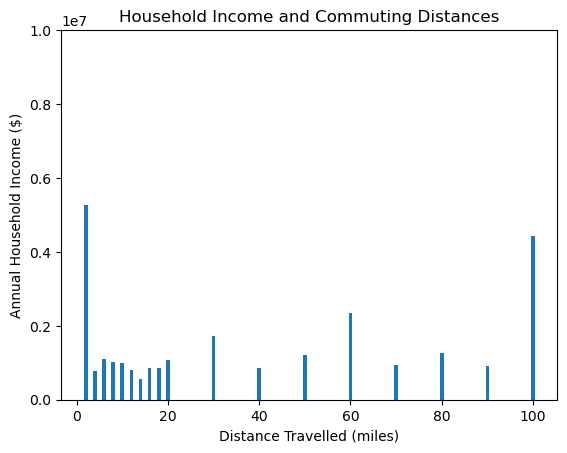

In [60]:
# Get hh income and their commuting distance
df_income_dist = df[['HINCP', 'COMDAYS', 'DRIVEALL', 'DIST']]
df_income_dist = df_income_dist[(df_income_dist['COMDAYS']>=1) & (df_income_dist['COMDAYS']<=7)
                                & (df_income_dist['DRIVEALL']>=1) & (df_income_dist['DRIVEALL']<=7)
                                & (df_income_dist['DIST'] > 0 )]

plt.bar(df_income_dist['DIST'], df_income_dist['HINCP'])
plt.xlabel('Distance Travelled (miles)')
plt.ylabel('Annual Household Income ($)')
plt.title('Household Income and Commuting Distances')
plt.ylim([0, 10000000])

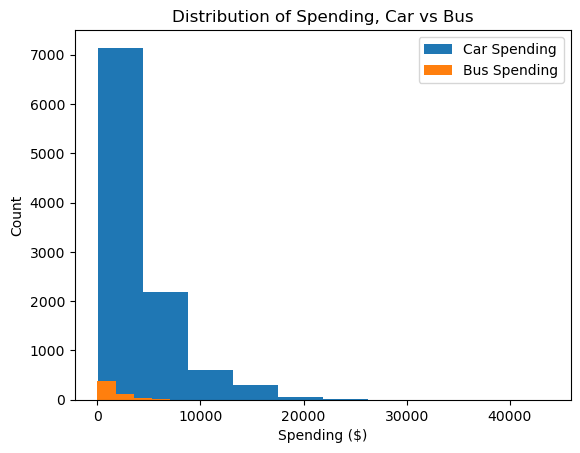

In [61]:
# Get average cost of people who drive and people who take the bus 
df_costs = df[['HINCP', 'COMDAYS', 'COMTYPE', 'COMCOST']]
df_cost_drive = df_costs[(df_costs['COMDAYS'] >= 1) & (df_costs['COMDAYS'] <=7 )
                         & (df_costs['COMTYPE'] == 1) & (df_costs['COMCOST'] >= 0)]
df_cost_bus = df_costs[(df_costs['COMDAYS'] >= 1) & (df_costs['COMDAYS'] <=7 )
                        & (df_costs['COMTYPE'] == 2) & (df_costs['COMCOST'] >= 0)]

plt.hist(df_cost_drive['COMCOST'], label = 'Car Spending')
plt.hist(df_cost_bus['COMCOST'], label = 'Bus Spending')
plt.legend()
plt.xlabel('Spending ($)')
plt.ylabel('Count')
plt.title('Distribution of Spending, Car vs Bus')
plt.show()

# Setting up mobility insecurity metric
Transportation insecurity can be divided into five major areas: availability, accessibility, accommodation, affordability, and acceptability. While in the first part we have gained an understanding on the economic stress of transportation, it is also important to understand the "soft" metrics of mobility insecurity, which includes availability, accessibility, and accommodation. Therefore, this section will start with setting up a new mobility insecurity metric, that takes into consideration both the connectivity of the living unit and overall commuting stress.\

The insecurity metric will be a total of 20. The higher, the more mobility insecurity that the household might face. Based on the exiting resource, here is how the insecurity metric will be calculated:\ Living situation:

1. -1 NHQSCHOOL = 2 (Disagree on having close proximity to schools)
2. -3 NHQPUBTRN = 2 (Disagree on having close proximity to public transportation)
3. -1 GARAGE !=’1’ (No garage)\
Mobility:

1. -1 COMDAYS>5 (Commute for more than 5 days a week)
2. -2 DRIVEALL>5 (Drive for more than 5 days of a week for commute)
3. -4 DIST >40 (40 miles is average daily commute distance for Americans)
4. -4 if BUS, SUBWAY, VAN = 1 AND NHQPUBTRN = 0 (Take public transportation while no reported good public transportation near residence)
5. -4 if SUBSIDY = 3 (no subsidy for public transportation) \
Source: Gould-Werth, Alix, Jamie Griffin, and Alexandra K. Murphy. "Developing a new measure of transportation insecurity: an exploratory factor analysis." Survey Practice 11, no. 2 (2018).

In [62]:
# Set up a column for df score
df['INSECURITY'] = 0

In [63]:
# Define a function of metric calculation
def calculate_df(row): 
    i = 0
    if row['NHQSCHOOL'] == 2: i -= 1
    if row['NHQPUBTRN'] == 2: i-= 3
    if row['GARAGE'] != 1: i -= 1
    if row['COMDAYS'] >5: i -= 1
    if row['DRIVEALL'] >5: i -= 2
    if row['DIST'] >40: i -= 4
    if (row[['BUS', 'SUBWAY', 'VAN']].eq(1).any()) & (row['NHQPUBTRN'] == 2): 
        i -= 4
    if row['SUBSIDY'] ==3: i -= 4
    row['INSECURITY'] = i
    return row['INSECURITY']

df['INSECURITY'] = df.apply(calculate_df, axis=1)
df['INSECURITY'].unique()

array([ -3.,   0.,  -4.,  -1.,  -5.,  -7.,  -2.,  -6., -11.,  -8., -12.,
       -16., -10., -13.,  -9., -15., -17., -14., -19.])

(array([1.0000e+00, 1.7000e+01, 5.4000e+01, 1.0700e+02, 2.9700e+02,
        5.0900e+02, 1.8360e+03, 1.0134e+04, 1.7377e+04, 2.7652e+04]),
 array([-19. , -17.1, -15.2, -13.3, -11.4,  -9.5,  -7.6,  -5.7,  -3.8,
         -1.9,   0. ]),
 <BarContainer object of 10 artists>)

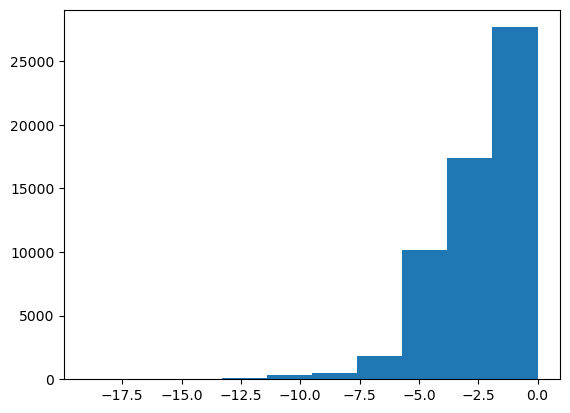

In [64]:
plt.hist(df['INSECURITY'])

# Setting up transportation load metric

In [65]:
# Make sure that all COMCOST and HINCP are above 0
df = df.loc[(df['COMCOST'] > 0) & (df['HINCP'] > 0)]
df['load'] = df['COMCOST']/df['HINCP']
df = df[(df['load'] < 1)]
df['load'].describe()

count    12450.000000
mean         0.068507
std          0.097776
min          0.000047
25%          0.015456
50%          0.037089
75%          0.081205
max          0.983535
Name: load, dtype: float64

In [66]:
df

,YRBUILT,FOUNDTYPE,BLD,UNITSIZE,HEATFUEL,WATSOURCE,ADEQUACY,MOVWHY,RMJOB,RMOWNHH,...,DRIVEALL,DIST,BUS,SUBWAY,VAN,COMTYPE,COMCOST,SUBSIDY,INSECURITY,load
4,1960,2.0,2,7.0,2,1,1,NaN,NaN,NaN,...,5.0,40.0,2.0,2.0,2.0,1.0,5564.0,NaN,-4.0,0.025325
6,1970,3.0,2,3.0,2,1,1,NaN,NaN,NaN,...,5.0,2.0,2.0,2.0,2.0,3.0,278.0,NaN,-1.0,0.120870
8,1980,2.0,2,8.0,2,1,1,NaN,NaN,NaN,...,5.0,16.0,2.0,2.0,2.0,1.0,2226.0,NaN,-3.0,0.044167
14,1980,NaN,4,3.0,1,1,2,NaN,1.0,1.0,...,5.0,10.0,2.0,2.0,2.0,1.0,1391.0,NaN,-1.0,0.010766
16,1950,3.0,2,4.0,2,1,2,NaN,NaN,NaN,...,5.0,40.0,2.0,2.0,2.0,1.0,5564.0,NaN,0.0,0.055640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57964,2015,NaN,8,1.0,1,1,1,NaN,NaN,NaN,...,6.0,2.0,2.0,2.0,2.0,1.0,334.0,NaN,-7.0,0.006958
57974,2015,1.0,2,8.0,1,1,1,NaN,2.0,2.0,...,5.0,10.0,2.0,2.0,2.0,1.0,1391.0,NaN,-3.0,0.009935
57977,2015,1.0,3,9.0,2,1,1,NaN,NaN,NaN,...,5.0,100.0,2.0,2.0,2.0,1.0,13910.0,NaN,-7.0,0.065551
57979,2015,1.0,2,4.0,3,2,1,NaN,2.0,1.0,...,5.0,20.0,2.0,2.0,2.0,1.0,2782.0,NaN,-3.0,0.016365


# Remainder of data cleaning

### Housing Unit Characteristics

In [67]:
#Housing Unit Characteristics
df['YRBUILT'].isnull().sum(axis=0)

0

In [68]:
#* FOUNDTYPE - Foundation type
#    * Single family: FOUNDTYPE IN (1,2,3,4)
#    * Manufactured/mobile home: FOUNDTYPE IN (5,6,7,8)
#    * Other: FOUNDTYPE = 9 

conditions = [
    (df['FOUNDTYPE'].isin([1, 2, 3, 4])),
    (df['FOUNDTYPE'].isin([5, 6, 7, 8])),
]

categories = ['SINGLEFAM', 'MOBILE']
# Create a new column with categories based on conditions
df['FOUNDTYPE'] = np.select(conditions, categories, default='Uncategorized')
df = pd.get_dummies(df, columns = ['FOUNDTYPE'], drop_first= True)



### General Housing

In [69]:
conditions = [
    (df['BLD'] == 1),
    (df['BLD'] == 2),
    (df['BLD'] == 3),
    (df['BLD'].isin([4,5,6])),
    (df['BLD'] == 7),
    (df['BLD'].isin([8,9]))
]

categories = ['MOBILE' ,'SINGLEDETCH', 'SINGLEATTACHED', 
              'LOWDEN', 'MIDDEN', 'HIGHDEN']

# Create a new column with categories based on conditions
df['BLD'] = np.select(conditions, categories, default='Uncategorized')
df = pd.get_dummies(df, columns = ['BLD'], drop_first= True)

### Rooms, Size, Amenities

In [70]:
#Rooms, Size, Amenities
#* UNITSIZE - Square footage of unit 
df['UNITSIZE'].interpolate(method = 'linear', inplace=True)
df['UNITSIZE'].isnull().sum(axis=0)

0

### Heating, AC, Appliances

In [71]:
conditions = [
    (df['HEATFUEL'] == 1),
    (df['HEATFUEL'] == 2),
    (df['HEATFUEL'] == 3),
    (df['HEATFUEL'] == 4),
    (df['HEATFUEL'] == 5),
    (df['HEATFUEL'] == 6),
    (df['HEATFUEL'] == 7),
    (df['HEATFUEL'] == 8),
]

categories = ['ELEC', 'PIPEDGAS', 'BOTGAS', 
              'FUELOIL', 'KEROSENE', 'COALCOKE', 
              'WOOD', 'SOLAR'] 

# Create a new column with categories based on conditions
df['HEATFUEL'] = np.select(conditions, categories, default='Uncategorized')
df = pd.get_dummies(df, columns = ['HEATFUEL'], drop_first= True)


### Plumbing, Water, Sewage

In [72]:
conditions = [
    (df['WATSOURCE'] == 1),
    (df['WATSOURCE'] == 2)
]

categories = ['SYSTEM', 'INDIVWELL'] 

# Create a new column with categories based on conditions
df['WATSOURCE'] = np.select(conditions, categories, default='Uncategorized')
df = pd.get_dummies(df, columns = ['WATSOURCE'], drop_first= True)

### Housing Quality 

In [73]:
conditions = [
    (df['ADEQUACY'] == 1),
    (df['ADEQUACY'] == 2),
    (df['ADEQUACY'] == 3)
]

categories = ['ADEQUATE', 'MOD_INAD', 'SEV_INAD']

# Create a new column with categories based on conditions
df['ADEQUACY'] = np.select(conditions, categories, default='Uncategorized')
df = pd.get_dummies(df, columns = ['ADEQUACY'], drop_first= True)

### Migration (Reasons for Leaving Previous Residence)

In [74]:
conditions = [
    (df['MOVWHY'] == 1),
    (df['MOVWHY'] == 2)
]

categories = ['MOVE_FINANCE', 'MOVE_DISASTER']

# Create a new column with categories based on conditions
df['MOVWHY'] = np.select(conditions, categories, default='Uncategorized')
df = pd.get_dummies(df, columns = ['MOVWHY'], drop_first= True)


In [75]:

col_list = ['RMJOB', 'RMOWNHH', 
            'RMFAMILY', 'RMCHANGE', 'RMCOMMUTE', 'RMHOME', 'RMCOSTS', 
            'RMHOOD', 'RMOTHER']
for col in col_list: 
#    print(df[col].isnull().sum(axis=0))
    df[col].fillna(0, inplace = True)
#    print(df[col].isnull().sum(axis=0))



### Neighbourhood Search

In [76]:
#Neighbourhood Search 
#* SEARCHSTOP != 'N' & NRATE: Comparison to previous neighbourhood
#    * Better neighbourhood - 1
#    * Worse neighbourhood - 2
#    * About the same - 3
#    * Same neighbourhood - 4

conditions = [
    (df['SEARCHSTOP'] != 'N') & (df['NRATE'] == 1),
    (df['SEARCHSTOP'] != 'N') & (df['NRATE'] == 2),
    (df['SEARCHSTOP'] != 'N') & (df['NRATE'] == 3),
    (df['SEARCHSTOP'] != 'N') & (df['NRATE'] == 4)
]

categories = ['BETTER_NH', 'WORSE_NH', 'ABOUT_NH', 'SAME_NH']

# Create a new column with categories based on conditions
df['NRATE'] = np.select(conditions, categories, default='Uncategorized')
df = pd.get_dummies(df, columns = ['NRATE'], drop_first= True)
df = df.drop(['SEARCHSTOP'], axis = 1)

### Demographics

In [77]:
# Categorize race correctly 
# Reassign into specific categories: White, Black, Native, Asian, Pacific Islander, Two or More

# Define the conditions and corresponding categories
conditions = [
    (df['HHRACE'] == 1),
    (df['HHRACE'] == 2),
    (df['HHRACE'] == 3),
    (df['HHRACE'] == 4),   
    (df['HHRACE'] == 5), 
    (df['HHRACE'].isin([6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]))
]

categories = ['White', 'Black', 'Native', 'Asian', 'Pacific', '2plus']

# Create a new column with categories based on conditions
df['HHRACE'] = np.select(conditions, categories, default='Uncategorized')
df = pd.get_dummies(df, columns = ['HHRACE'], drop_first= True)

In [78]:
# Categorize education status correctly
# Reassign into specific categories: <HS, HS, Associate, Bacherlors, Graduate
# <HS: HHGRAD in ('31' '32' '33' '34') or (HHGRAD = 'M') and HHGRAD in ('35' '36' '37' '38')
# HS:  (HHGRAD = '39' or HHGRAD = '41'), HHGRAD = '41', HHGRAD = '40'
# Associate's degree, HHGRAD in ('42' '43')
# Bachelor's degree, HHGRAD = '44'
# Graduate degree, HHGRAD in ('45' '46' '47')

# Define the conditions and corresponding categories
conditions = [
    (df['HHGRAD'] >= 31) & (df['HHGRAD'] < 39),
    (df['HHGRAD'] >= 39) & (df['HHGRAD'] < 42),
    (df['HHGRAD'] >= 42) & (df['HHGRAD'] < 44),
    (df['HHGRAD'] == 44),
    (df['HHGRAD'] >= 45) & (df['HHGRAD'] < 48)
]

categories = ['noHS', 'HS', 'A_deg', 'B_deg', 'Grad_deg']

# Create a new column with categories based on conditions
df['HHGRAD'] = np.select(conditions, categories, default='Uncategorized')
df = pd.get_dummies(df, columns = ['HHGRAD'], drop_first= True)

In [79]:
# Clean HHCITSHP 
# Define the conditions and corresponding categories
conditions = [
    (df['HHCITSHP'].isin(['1','2','3','4'])),
    (df['HHCITSHP'] == '5'),
]

categories = ['Cit', 'NotCit']

# Create a new column with categories based on conditions
df['HHCITSHP'] = np.select(conditions, categories, default='Uncategorized')
df = pd.get_dummies(df, columns = ['HHCITSHP'], drop_first= True)

In [80]:
# Num peoples
df['NUMPEOPLE'].interpolate(method = 'linear', inplace=True)
df['NUMPEOPLE'].isnull().sum(axis=0)


0

In [81]:
# Clean multigen 
df['MULTIGEN'] = df['MULTIGEN'].astype(int)

# Define the conditions and corresponding categories
conditions = [
    (df['MULTIGEN'] == 3) | (df['MULTIGEN'] == 4) | (df['MULTIGEN'] == 6)]

categories = ['Multi']

# Create a new column with categories based on conditions
df['MULTIGEN'] = np.select(conditions, categories, default='NotMulti')
df = pd.get_dummies(df, columns = ['MULTIGEN'], drop_first= True)


### Disabilities

In [82]:
# DISHH is 1 if household has disability, 2 if it doesn't
df = pd.get_dummies(df, columns = ['DISHH'], drop_first= True)

### Income and Housing Costs

In [83]:
# Calculating house load
df['house_load_month'] = df['TOTHCAMT']/(df['HINCP']/12)
df['house_load_month'].describe()

count    12450.000000
mean         0.310608
std          0.820442
min          0.000000
25%          0.139103
50%          0.216000
75%          0.334403
max         68.488479
Name: house_load_month, dtype: float64

### House Value, Price

In [84]:
# Clean marketval 
df['MARKETVAL'].interpolate(method = 'linear', inplace=True)

### Rent Sub & Rent Management

In [85]:
# Categorize rent control and support 
# Rent Sub & Rent Mgmt
# * RENTCNTRL
#    * Controlled - 1
#    * No rent control - 2

# Define the conditions and corresponding categories
conditions = [
    (df['RENTCNTRL'] == 1),
    (df['RENTCNTRL'] == 2)
]

categories = ['RNT_CONTROLLED', 'NOT_RNT_CONTROLLED']

# Create a new column with categories based on conditions
df['RENTCNTRL'] = np.select(conditions, categories, default='Uncategorized')
df = pd.get_dummies(df, columns = ['RENTCNTRL'], drop_first= True)

In [86]:
#* HUDSUB
#    * Public housing - 1
#    * Voucher - 2
#    * Privately owned subsizied housing - 1
#    * No government rental assisstance - 3

conditions = [
    (df['HUDSUB'] == 1),
    (df['HUDSUB'] == 2),
    (df['HUDSUB'] == 3) 
]

categories = ['PUBLIC_H_SUBS', 'VOUCHER', 'NONE']

# Create a new column with categories based on conditions
df['HUDSUB'] = np.select(conditions, categories, default='Uncategorized')
df = pd.get_dummies(df, columns = ['HUDSUB'], drop_first= True)

### Neighbourhoods

In [87]:
# Checking Neighbourhood Ratings
df.loc[~df['RATINGNH'].between(1, 10), 'RATINGNH'] = 5
df['RATINGNH'].value_counts()

8.0     3383
10.0    3313
9.0     2131
7.0     1887
6.0      741
5.0      618
4.0      161
3.0       93
1.0       67
2.0       56
Name: RATINGNH, dtype: int64

In [88]:
# Opinion of neighbourhoods - school 
conditions = [
    (df['NHQSCHOOL'] == 1),
    (df['NHQSCHOOL'] == 2)]

categories = ['GoodSchool', 'BadSchool']

# Create a new column with categories based on conditions
df['NHQSCHOOL'] = np.select(conditions, categories, default='NotReported')
df = pd.get_dummies(df, columns = ['NHQSCHOOL'], drop_first= True)

In [89]:
# Opinion of neighbourhood - tranportation
conditions = [
    (df['NHQPUBTRN'] == 1),
    (df['NHQPUBTRN'] == 2)]

categories = ['GoodTranp', 'BadTranp']

# Create a new column with categories based on conditions
df['NHQPUBTRN'] = np.select(conditions, categories, default='NotReported')
df = pd.get_dummies(df, columns = ['NHQPUBTRN'], drop_first= True)

### Disaster Prep

In [90]:
# Is an evacuation vehicle available? 
conditions = [
    (df['DPEVVEHIC'] == 1),
    (df['DPEVVEHIC'] == 2)]

categories = ['EVAC_AV', 'EVAC_NAV']

# Create a new column with categories based on conditions
df['DPEVVEHIC'] = np.select(conditions, categories, default='NotReported')
df = pd.get_dummies(df, columns = ['DPEVVEHIC'], drop_first= True)

### Deliquent Payments

In [91]:
# Miss mortgages?
conditions = [
    (df['DBMISSMORT'] == 1),
    (df['DBMISSMORT'] == 2)]

categories = ['ON_TIME', 'LATE']

# Create a new column with categories based on conditions
df['DBMISSMORT'] = np.select(conditions, categories, default='NotReported')
df = pd.get_dummies(df, columns = ['DBMISSMORT'], drop_first= True)

### Commuting and Commuting Costs

In [92]:
# Checking commuting days
df.loc[~df['COMDAYS'].between(0, 7), 'COMDAYS'] = 4
df['COMDAYS'].value_counts()

5.0    8756
6.0    1100
4.0    1080
3.0     673
7.0     388
2.0     289
1.0     164
Name: COMDAYS, dtype: int64

In [93]:
df['DRIVEALL'].interpolate(method = 'linear', inplace=True)

In [94]:
# Check if distance is all valid numbers
df['DIST'].interpolate(method = 'linear', inplace=True)

In [95]:
# Categorize commuting mode
df['COMTYPE'] = df['COMTYPE'].astype(int)

conditions = [
    (df['COMTYPE'] == 1),
    (df['COMTYPE'] == 2),
    (df['COMTYPE'] == 3),
    (df['COMTYPE'] == 4),
    (df['COMTYPE'] == 5),
    (df['COMTYPE'] == 6), 
    (df['COMTYPE'] == 0)]

categories = ['Driveall', 'Ptall', 'Multimode', 'Carpool', 'Compcar', 'Walkbike', 'Nocommute']

# Create a new column with categories based on conditions
df['COMTYPE'] = np.select(conditions, categories, default='NotReported')
df = pd.get_dummies(df, columns = ['COMTYPE'], drop_first= True)

In [96]:
conditions = [
    (df['BUS'] == 1)]

categories = ['YES']

# Create a new column with categories based on conditions
df['BUS'] = np.select(conditions, categories, default='NotReported')
df = pd.get_dummies(df, columns = ['BUS'], drop_first= True)

conditions = [
    (df['SUBWAY'] == 1)]

categories = ['YES']

# Create a new column with categories based on conditions
df['SUBWAY'] = np.select(conditions, categories, default='NotReported')
df = pd.get_dummies(df, columns = ['SUBWAY'], drop_first= True)

conditions = [
    (df['VAN'] == 1)]

categories = ['Yes']

# Create a new column with categories based on conditions
df['VAN'] = np.select(conditions, categories, default='NotReported')
df = pd.get_dummies(df, columns = ['VAN'], drop_first= True)


In [97]:
# Categorize subsidy

conditions = [
    (df['SUBSIDY'] == 1),
    (df['SUBSIDY'] == 2),
    (df['SUBSIDY'] == 3)]

categories = ['Full', 'Partial', 'None']

# Create a new column with categories based on conditions
df['SUBSIDY'] = np.select(conditions, categories, default='NotReported')
df = pd.get_dummies(df, columns = ['SUBSIDY'], drop_first= True)

In [98]:
# Opinion of neighbourhood - tranportation
conditions = [
    (df['GARAGE'] == 1),
    (df['GARAGE'] == 2)]

categories = ['Garage', 'NoGarage']

# Create a new column with categories based on conditions
df['GARAGE'] = np.select(conditions, categories, default='NotReported')
df = pd.get_dummies(df, columns = ['GARAGE'], drop_first= True)

In [99]:
# Check for nulls
print(df.isnull().sum(axis=0).sum())

0


In [100]:
df.columns

Index(['YRBUILT', 'UNITSIZE', 'RMJOB', 'RMOWNHH', 'RMFAMILY', 'RMCHANGE',
       'RMCOMMUTE', 'RMHOME', 'RMCOSTS', 'RMHOOD', 'RMOTHER', 'HINCP',
       'NUMPEOPLE', 'MARKETVAL', 'RATINGNH', 'TOTHCAMT', 'COMDAYS', 'DRIVEALL',
       'DIST', 'COMCOST', 'INSECURITY', 'load', 'FOUNDTYPE_SINGLEFAM',
       'FOUNDTYPE_Uncategorized', 'BLD_LOWDEN', 'BLD_MIDDEN', 'BLD_MOBILE',
       'BLD_SINGLEATTACHED', 'BLD_SINGLEDETCH', 'BLD_Uncategorized',
       'HEATFUEL_COALCOKE', 'HEATFUEL_ELEC', 'HEATFUEL_FUELOIL',
       'HEATFUEL_KEROSENE', 'HEATFUEL_PIPEDGAS', 'HEATFUEL_SOLAR',
       'HEATFUEL_Uncategorized', 'HEATFUEL_WOOD', 'WATSOURCE_SYSTEM',
       'WATSOURCE_Uncategorized', 'ADEQUACY_MOD_INAD', 'ADEQUACY_SEV_INAD',
       'MOVWHY_MOVE_FINANCE', 'MOVWHY_Uncategorized', 'NRATE_BETTER_NH',
       'NRATE_SAME_NH', 'NRATE_Uncategorized', 'NRATE_WORSE_NH',
       'HHRACE_Asian', 'HHRACE_Black', 'HHRACE_Native', 'HHRACE_Pacific',
       'HHRACE_White', 'HHGRAD_B_deg', 'HHGRAD_Grad_deg', 'HHGRAD_HS'

In [101]:
df_2 = df.drop(columns = ['HINCP', 'COMCOST'], axis =1)

In [102]:
df_2.to_csv('occupied_features_cleaned.csv')

In [103]:
df.to_csv('occupied_features_withincome.csv')